In [15]:
import pyfolio as pf
%matplotlib inline
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [18]:
config=json.loads(open('./config/huobi_config.json','r').read())
ACCESS_KEY=config['ACCESS_KEY']
SECRET_KEY=config['SECRET_KEY']

In [19]:
# -*- coding:utf-8 -*-
from abc import abstractmethod


class Agent(object):
    def __init__(self):
        pass
    
    @abstractmethod
    def trade(self, state):
        pass
    
    def train(self):
        pass
    
    @abstractmethod
    def load_model(self, model_path):
        pass
    
    @abstractmethod
    def save_model(self, model_path):
        pass

In [20]:
# -*- coding:utf-8 -*-
import os
import pandas as pd
import talib
import numpy as np
from collections import OrderedDict
from utils.HuobiServices import *

lmap = lambda func, it: list(map(lambda x: func(x), it))
lfilter = lambda func, it: list(filter(lambda x: func(x), it))


class CryptoCurrencyEnv(object):
    def __init__(self, instruments,
                 access_key,
                 secret_key,
                 base_currency='btc',
                 capital_base=1,
                 data_local_path='./data',
                 re_download=False,
                 commission_fee=5e-3,
                 normalize_length=10,
                 data_interval='60min'
                 ):

        self.secret_key = secret_key
        self.access_key = access_key
        init_account(self.access_key, self.secret_key)

        self.instruments = instruments
        self.base_currency = base_currency
        self.capital_base = capital_base
        self.commission_fee = commission_fee
        self.normalize_length = normalize_length
        self.data_local_path = data_local_path
        self.data_interval = data_interval

        self.market_data = self._init_market_data(re_download=re_download)
        self.pointer = normalize_length - 1
        self.done = (self.pointer == (self.market_data.shape[1] - 1))

        self.current_position = np.zeros(len(self.instruments))
        self.current_portfolio_value = np.concatenate((np.zeros(len(self.instruments)), [self.capital_base]))
        self.current_weight = np.concatenate((np.zeros(len(self.instruments)), [1.]))
        self.current_date = self.market_data.major_axis[self.pointer]

        self.portfolio_values = []
        self.positions = []
        self.weights = []
        self.trade_dates = []

    def reset(self):
        self.pointer = self.normalize_length
        self.current_position = np.zeros(len(self.instruments))
        self.current_portfolio_value = np.concatenate((np.zeros(len(self.instruments)), [self.capital_base]))
        self.current_weight = np.concatenate((np.zeros(len(self.instruments)), [1.]))
        self.current_date = self.market_data.major_axis[self.pointer]
        self.done = (self.pointer == (self.market_data.shape[1] - 1))

        self.portfolio_values = []
        self.positions = []
        self.weights = []
        self.trade_dates = []

        return self._get_normalized_state(), self.done

    def step(self, action):
        assert action.shape[0] == len(self.instruments) + 1
        assert np.sum(action) <= 1 + 1e5
        current_price = self.market_data[:, :, 'close'].iloc[self.pointer].values
        self._rebalance(action=action, current_price=current_price)

        self.pointer += 1
        self.done = (self.pointer == (self.market_data.shape[1] - 1))
        next_price = self.market_data[:, :, 'close'].iloc[self.pointer].values
        reward = self._get_reward(current_price=current_price, next_price=next_price)
        state = self._get_normalized_state()
        return state, reward, self.done

    def _rebalance(self, action, current_price):
        target_weight = action
        target_value = np.sum(self.current_portfolio_value) * target_weight
        target_position = target_value[:-1] / current_price
        trade_amount = target_position - self.current_position
        commission_cost = np.sum(self.commission_fee * np.abs(trade_amount) * current_price)

        self.current_position = target_position
        self.current_portfolio_value = target_value - commission_cost
        self.current_weight = target_weight
        self.current_date = self.market_data.major_axis[self.pointer]

        self.positions.append(self.current_position.copy())
        self.weights.append(self.current_weight.copy())
        self.portfolio_values.append(self.current_portfolio_value.copy())
        self.trade_dates.append(self.current_date)

    def _get_normalized_state(self):
        data = self.market_data.iloc[:, self.pointer + 1 - self.normalize_length:self.pointer + 1, :].values
        state = ((data - np.mean(data, axis=1, keepdims=True)) / (np.std(data, axis=1, keepdims=True) + 1e-5))[:, -1, :]
        return np.concatenate((state, self.current_weight[:-1][:, None]), axis=1)

    def get_meta_state(self):
        return self.market_data.iloc[:, self.pointer, :]

    def _get_reward(self, current_price, next_price):
        return_rate = (next_price / current_price)
        log_return = np.log(return_rate)
        last_weight = self.current_weight.copy()
        securities_value = self.current_portfolio_value[:-1] * return_rate
        self.current_portfolio_value[:-1] = securities_value
        self.current_weight = self.current_portfolio_value / np.sum(self.current_portfolio_value)
        reward = last_weight[:-1] * log_return
        return reward

    def _init_market_data(self, data_name='crc_market_data.pkl', re_download=False):
        data_path = self.data_local_path + '/' + data_name
        if not os.path.exists(self.data_local_path):
            os.mkdir(self.data_local_path)
        if not os.path.exists(data_path) or re_download:
            print('Start to download crc market data')
            market_data = CryptoCurrencyEnv.klines(instruments=self.instruments,
                                                   base_currency=self.base_currency,
                                                   interval=self.data_interval)
            market_data = CryptoCurrencyEnv._pre_process(market_data, open_c='open', high_c='high', low_c='low', close_c='close', volume_c='vol')
            market_data.to_pickle(data_path)
            print('Done')
        else:
            print('market data exist, loading')
            market_data = pd.read_pickle(data_path).fillna(method='ffill').fillna(method='bfill')
        return market_data

    def get_summary(self):
        portfolio_value_df = pd.DataFrame(np.array(self.portfolio_values), index=np.array(self.trade_dates), columns=self.instruments + ['cash'])
        positions_df = pd.DataFrame(np.array(self.positions), index=np.array(self.trade_dates), columns=self.instruments)
        weights_df = pd.DataFrame(np.array(self.weights), index=np.array(self.trade_dates), columns=self.instruments + ['cash'])
        return portfolio_value_df, positions_df, weights_df

    @staticmethod
    def _pre_process(market_data, open_c, high_c, low_c, close_c, volume_c):
        market_data = lmap(lambda x: (x[0], CryptoCurrencyEnv._get_indicators(x[1], close_name=close_c, high_name=high_c, low_name=low_c, open_name=open_c, volume_name=volume_c)), market_data)
        market_data = OrderedDict(market_data)
        market_data = pd.Panel(market_data)
        return market_data

    @staticmethod
    def kline(instrument, base_currency='btc', interval='60min', count=2000):
        s = get_kline('{0}{1}'.format(instrument, base_currency), interval, count)
        if s is None: return None
        s = s['data']
        s = pd.DataFrame(s)[::-1]
        if s.shape[0] < count:
            return None
        s.index = pd.DatetimeIndex(s['id'].apply(lambda x: datetime.datetime.utcfromtimestamp(x) + datetime.timedelta(hours=8)))
        s = s.drop('id', axis=1)
        s['AVG'] = (np.mean(s[['open', 'high', 'low', 'close']], axis=1))
        s['LOG_RR'] = np.log(s['close'] / s['close'].shift(1)).fillna(0)
        s['RR'] = s['close'] / s['close'].shift(1)
        return s

    @staticmethod
    def klines(instruments, base_currency='btc', interval='60min', count=2000):
        return lfilter(lambda x: x[1] is not None, lmap(lambda x: (x, CryptoCurrencyEnv.kline(x, base_currency=base_currency, interval=interval, count=count)), instruments))

    @staticmethod
    def _get_indicators(stock, open_name, close_name, high_name, low_name, volume_name='vol'):
        open_price = stock[open_name].values
        close_price = stock[close_name].values
        low_price = stock[low_name].values
        high_price = stock[high_name].values
        volume = stock[volume_name].values
        data = stock.copy()
        data['MOM'] = talib.MOM(close_price)
        data['HT_DCPERIOD'] = talib.HT_DCPERIOD(close_price)
        data['HT_DCPHASE'] = talib.HT_DCPHASE(close_price)
        data['sine'], data['leadsine'] = talib.HT_SINE(close_price)
        data['inphase'], data['quadrature'] = talib.HT_PHASOR(close_price)
        data['ADXR'] = talib.ADXR(high_price, low_price, close_price)
        data['APO'] = talib.APO(close_price)
        data['AROON_UP'], _ = talib.AROON(high_price, low_price)
        data['CCI'] = talib.CCI(high_price, low_price, close_price)
        data['PLUS_DI'] = talib.PLUS_DI(high_price, low_price, close_price)
        data['PPO'] = talib.PPO(close_price)
        data['macd'], data['macd_sig'], data['macd_hist'] = talib.MACD(close_price)
        data['CMO'] = talib.CMO(close_price)
        data['ROCP'] = talib.ROCP(close_price)
        data['fastk'], data['fastd'] = talib.STOCHF(high_price, low_price, close_price)
        data['TRIX'] = talib.TRIX(close_price)
        data['ULTOSC'] = talib.ULTOSC(high_price, low_price, close_price)
        data['WILLR'] = talib.WILLR(high_price, low_price, close_price)
        data['NATR'] = talib.NATR(high_price, low_price, close_price)
        data['MFI'] = talib.MFI(high_price, low_price, close_price, volume)
        data['RSI'] = talib.RSI(close_price)
        data['AD'] = talib.AD(high_price, low_price, close_price, volume)
        data['OBV'] = talib.OBV(close_price, volume)
        data['EMA'] = talib.EMA(close_price)
        data['SAREXT'] = talib.SAREXT(high_price, low_price)
        data['TEMA'] = talib.EMA(close_price)
        data = data.drop([open_name, high_name, low_name, 'amount', 'count'], axis=1)
        data = data.dropna().astype(np.float32)
        return data


In [21]:
# -*- coding:utf-8 -*-
import torch
import torch.nn as nn
import torch.optim as optim
import os


class Actor(nn.Module):
    def __init__(self, s_dim, a_dim, b_dim, rnn_layers=1, dp=0.2):
        super(Actor, self).__init__()
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.b_dim = b_dim
        self.rnn_layers = rnn_layers
        self.gru = nn.GRU(self.s_dim, 128, self.rnn_layers, batch_first=True)
        self.fc_s_1 = nn.Linear(128, 128)
        self.fc_s_2 = nn.Linear(128, 64)
        self.fc_s_out = nn.Linear(64, 1)
        self.fc_pg_1 = nn.Linear(128, 128)
        self.fc_pg_2 = nn.Linear(128, 64)
        self.fc_pg_out = nn.Linear(64, self.a_dim)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=dp)
        self.softmax = nn.Softmax(dim=-1)
        self.initial_hidden = torch.zeros(self.rnn_layers, self.b_dim, 128, dtype=torch.float32)
    
    def forward(self, state, hidden=None, train=False):
        state, h = self.gru(state, hidden)
        if train:
            state = self.dropout(state)
        sn_out = self.relu(self.fc_s_1(state))
        sn_out = self.relu(self.fc_s_2(sn_out))
        sn_out = self.fc_s_out(sn_out)
        
        pn_out = self.relu(self.fc_pg_1(state))
        pn_out = self.relu(self.fc_pg_2(pn_out))
        pn_out = self.softmax(self.fc_pg_out(pn_out))
        return pn_out, sn_out, h.data


class RPGAgent(Agent):
    def __init__(self, s_dim, a_dim, b_dim, batch_length=64, learning_rate=1e-3, rnn_layers=1):
        super().__init__()
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.b_dim = b_dim
        self.batch_length = batch_length
        self.pointer = 0
        self.s_buffer = []
        self.a_buffer = []
        self.s_next_buffer = []
        self.r_buffer = []
        
        self.train_hidden = None
        self.trade_hidden = None
        self.actor = Actor(s_dim=self.s_dim, a_dim=self.a_dim, b_dim=self.b_dim, rnn_layers=rnn_layers)
        self.optimizer = optim.Adam(self.actor.parameters(), lr=learning_rate)
    
    def _trade(self, state, train=False):
        with torch.no_grad():
            a, _, self.trade_hidden = self.actor(state[:, None, :], self.trade_hidden, train=False)
        if train:
            return torch.multinomial(a[:, 0, :], 1)
        else:
            return a[:, 0, :].argmax(dim=1)
    
    def trade(self, state,train=False):
        state_ = torch.tensor(state,dtype=torch.float32)
        action = self._trade(state_,train=train)
        return action.numpy().flatten()
    
    def train(self):
        self.optimizer.zero_grad()
        s = torch.stack(self.s_buffer).t()
        s_next = torch.stack(self.s_next_buffer).t()
        r = torch.stack(self.r_buffer).t()
        a = torch.stack(self.a_buffer).t()
        a_hat, s_next_hat, self.train_hidden = self.actor(s, self.train_hidden, train=True)
        mse_loss = torch.nn.functional.mse_loss(s_next_hat, s_next)
        nll = -torch.log(a_hat.gather(2, a[:,:,None]))
        pg_loss = (nll * r).mean()
        loss = mse_loss + pg_loss
        loss.backward()
        for param in self.actor.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
    
    def reset_model(self):
        self.s_buffer = []
        self.a_buffer = []
        self.s_next_buffer = []
        self.r_buffer = []
        self.trade_hidden = None
        self.train_hidden = None
        self.pointer = 0
    
    def save_transition(self, state, action, reward, next_state):
        if self.pointer < self.batch_length:
            self.s_buffer.append(torch.tensor(state,dtype=torch.float32))
            self.a_buffer.append(torch.tensor(action))
            self.r_buffer.append(torch.tensor(reward[:, None], dtype=torch.float32))
            self.s_next_buffer.append(torch.tensor(next_state,dtype=torch.float32))
            self.pointer += 1
        else:
            self.s_buffer.pop(0)
            self.a_buffer.pop(0)
            self.r_buffer.pop(0)
            self.s_next_buffer.pop(0)
            self.s_buffer.append(torch.tensor(state,dtype=torch.float32))
            self.a_buffer.append(torch.tensor(action))
            self.r_buffer.append(torch.tensor(reward[:, None], dtype=torch.float32))
            self.s_next_buffer.append(torch.tensor(next_state,dtype=torch.float32))
    
    def load_model(self, model_path='./RPG_Torch'):
        self.actor = torch.load(model_path + '/model.pkl')
    
    def save_model(self, model_path='./RPG_Torch'):
        if not os.path.exists(model_path):
            os.mkdir(model_path)
        torch.save(self.actor, model_path + '/model.pkl')


In [22]:
env=CryptoCurrencyEnv(instruments=['eth','bat','mds','soc','wicc'],
                      access_key=ACCESS_KEY,
                      secret_key=SECRET_KEY,
                      re_download=True,commission_fee=0)

Start to download crc market data
Done


In [23]:
b_dim=env.market_data.shape[0]
s_dim=env.market_data.shape[-1]+1

In [24]:
agent=RPGAgent(a_dim=2,b_dim=b_dim,s_dim=s_dim,batch_length=64)

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

0.6521547055332106
0.8003683857340158
1.256572902944015
2.210979071706043


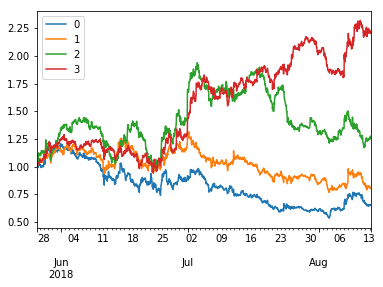

In [25]:
for e in tqdm_notebook(range(10)):
    state,done=env.reset()
    agent.reset_model()
    while not done:
        action=agent.trade(state,train=True)
        if action.sum()>0:
            action_normalized=np.concatenate((action,[0]))
            action_normalized=action_normalized/action_normalized.sum()
        else:
            action_normalized=np.concatenate((action,[1]))
        next_state,reward,done=env.step(action=action_normalized)
        next_log_rr=env.get_meta_state().loc['LOG_RR'].values[:,None]
        agent.save_transition(state=state,action=action,next_state=next_log_rr,reward=reward)
        state=next_state
        if env.pointer%64==0:
            agent.train()
    pv,pp,pw=env.get_summary()
    print(pv.iloc[-1].sum())
    total_pv=pv.sum(axis=1)
    total_pv.name=str(e)
    total_pv.plot(legend=True)
    if pv.iloc[-1].sum()>1.5:break

In [26]:
pv,pp,pw=env.get_summary()

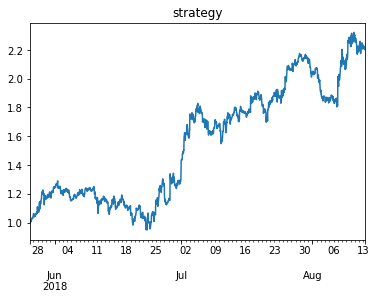

In [27]:
pv.sum(axis=1).plot()
plt.title('strategy')

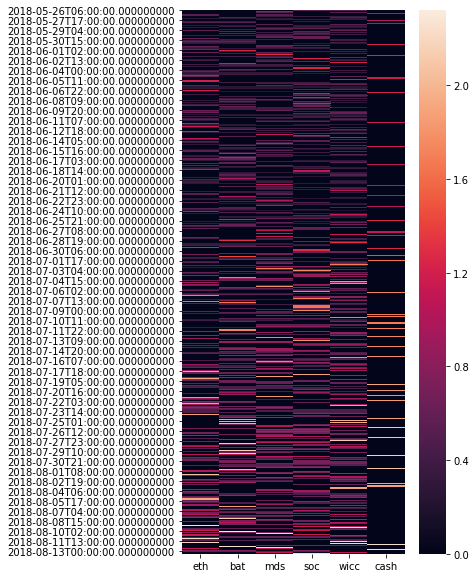

In [28]:
plt.figure(figsize=(5,10))
sns.heatmap(pv)

In [29]:
_,done=env.reset()
weight=np.concatenate((np.ones(len(env.instruments))/len(env.instruments),[0]))
while not done:
    _,_,done=env.step(action=weight)
    weight=env.current_weight

In [30]:
bpv,bpp,bpw=env.get_summary()

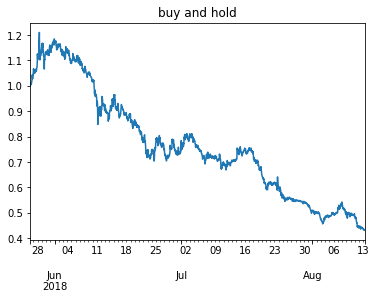

In [31]:
bpv.sum(axis=1).plot()
plt.title('buy and hold')

In [32]:
pr=pv.sum(axis=1).pct_change()
bpr=bpv.sum(axis=1).pct_change()

Entire data start date: 2018-05-26
Entire data end date: 2018-08-13
Backtest months: 90


,Backtest
Annual return,11.1%
Cumulative returns,121.1%
Annual volatility,18.3%
Sharpe ratio,0.67
Calmar ratio,0.42
Stability,0.82
Max drawdown,-26.5%
Omega ratio,1.15
Sortino ratio,1.08
Skew,2.02


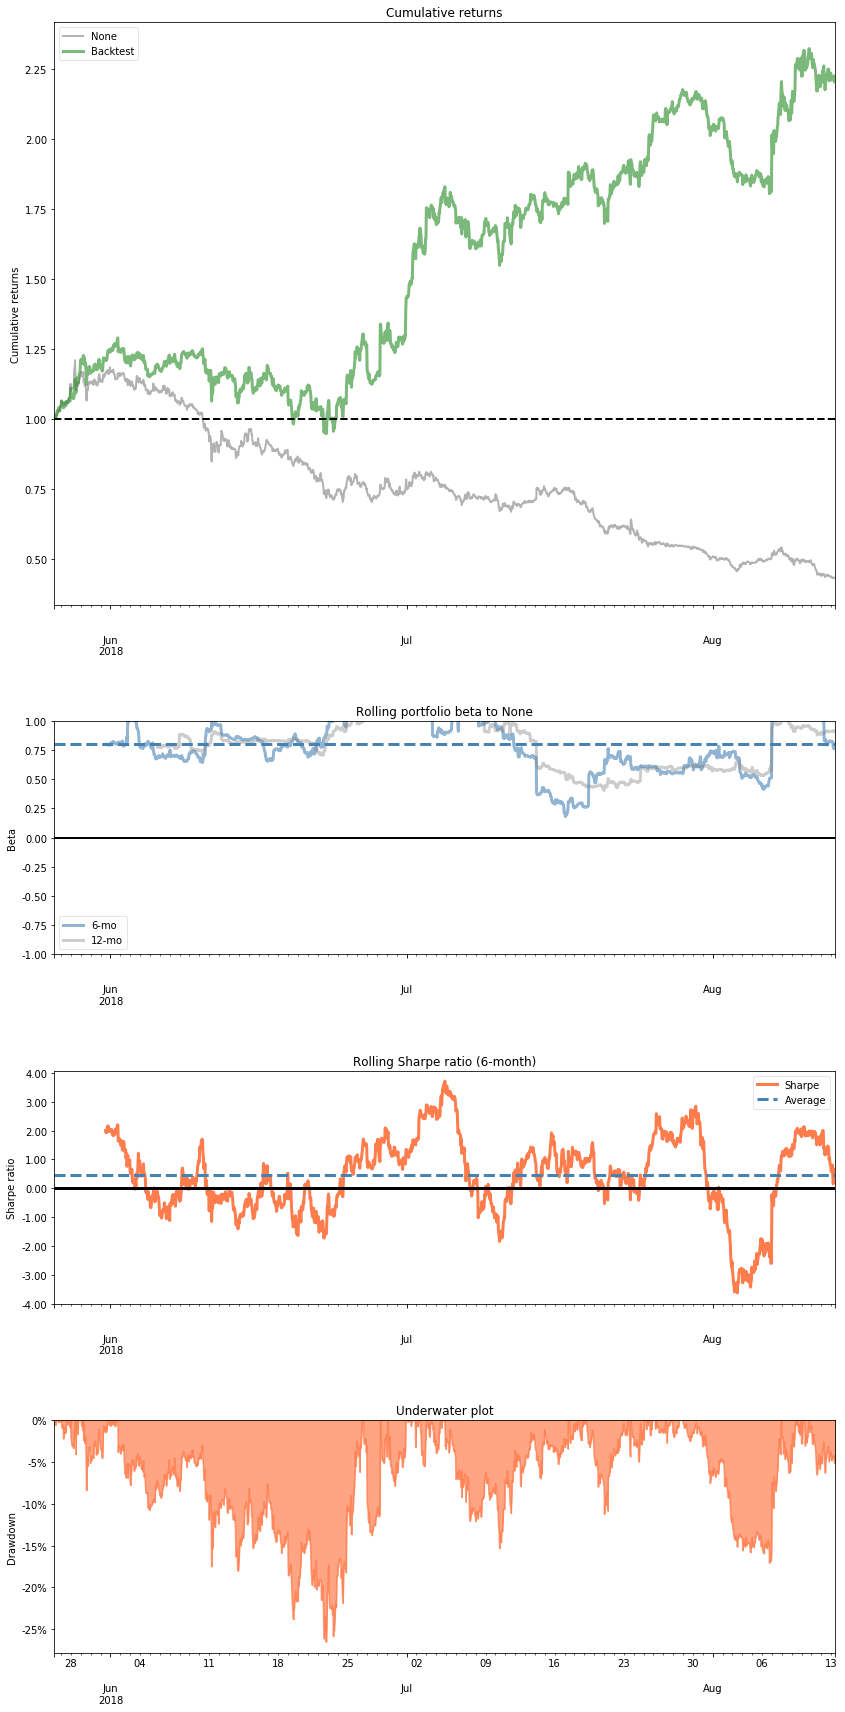

In [33]:
pf.create_simple_tear_sheet(returns=pr,benchmark_rets=bpr)

Top 10 long positions of all time,max
eth,100.00%
bat,100.00%
mds,100.00%
soc,100.00%
wicc,100.00%


Top 10 short positions of all time,max


Top 10 positions of all time,max
eth,100.00%
bat,100.00%
mds,100.00%
soc,100.00%
wicc,100.00%


All positions ever held,max
eth,100.00%
bat,100.00%
mds,100.00%
soc,100.00%
wicc,100.00%


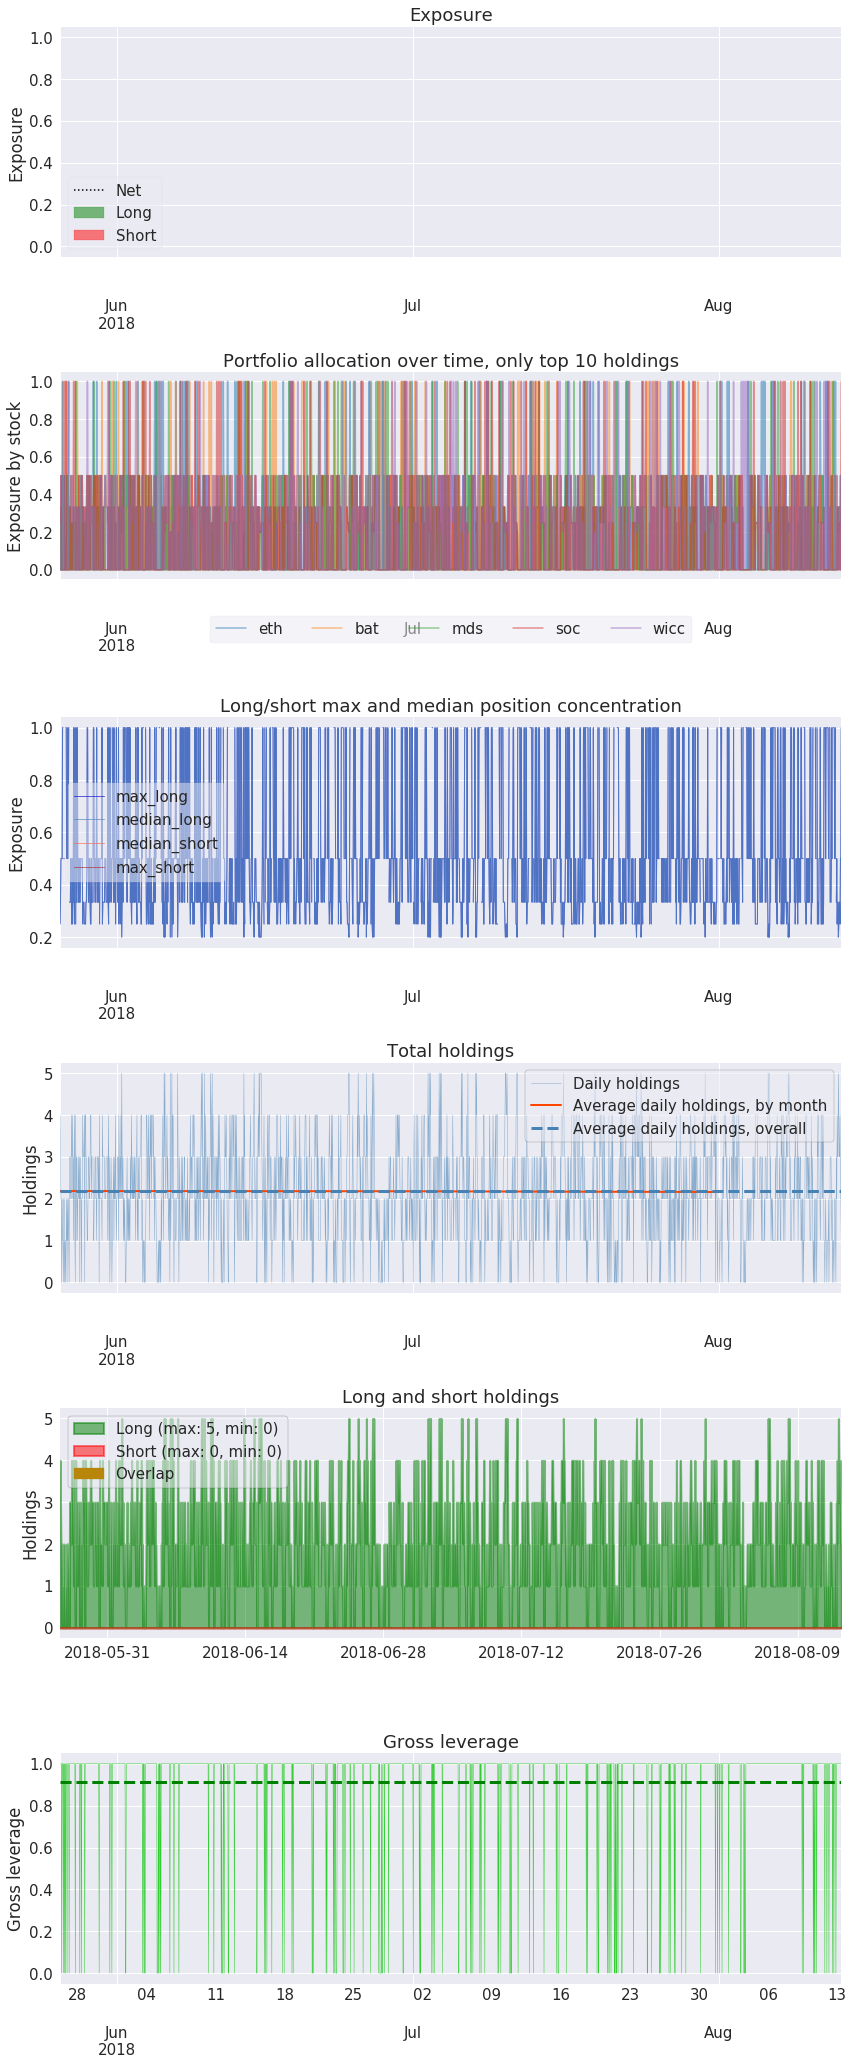

In [34]:
pf.create_position_tear_sheet(pr,pw*pv)